# Indeed.com:  Salary Prediction

In this notebook, we'll scrape Indeed.com for salary listings using the search term "Data Scientist," in the top 25 most-populous U.S. cities.  Then, we'll try to construct a logistic regression model to predict whether a given listing will have a salary that falls above or below the median of all training salaries.

First, we import and set up our environment:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import datetime
import requests
from bs4 import BeautifulSoup
import re

from scipy.stats import gaussian_kde
from nltk.stem.porter import *

from matplotlib import pyplot as plt
from matplotlib import cm as cm2
from matplotlib import patheffects as path_effects

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, \
                                    roc_auc_score, roc_curve, confusion_matrix, auc
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, \
                                    GridSearchCV
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_classif

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Here we go; let's scrape Indeed.com 'Data Scientist' job listings for the [top 25 most-populous cities](https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population) in the United States, up to a maximum of 1000 results per city.  Here are some functions we will use to process the scrapes:

In [2]:
def get_jobtitle(result):
    '''This function constructs a list containing each job title.'''
    jobtitle_list = []
    try:
        for i in result.findAll('a', class_ = 'jobtitle turnstileLink'): 
            jobtitle_list.append(str(i.text.encode('utf8')))
    except:
        jobtitle_list.append(None)
    return jobtitle_list

def get_location(result):
    '''This function constructs a list containing each job location.'''
    location_list = []
    try:
        for i in result.findAll('span', class_ = 'location'):
            location_list.append(str(i.text.encode('utf8')))
    except:
        location_list.append(None)
    return location_list

def get_company(result):   
    '''This function constructs a list containing each job company.'''
    company_list = []
    try:
        for i in result.findAll('span', class_ = 'company'):
            company = str(i.text.encode('utf8'))
            company = company.replace('\n', '')
            company = company.replace('    ', '')
            company_list.append(company)
    except:
        company_list.append(None)
    return company_list
    
def get_salary(result):
    '''This function constructs a list containing each job salary.'''
    salary_list = []
    try:
        for i in result.findAll('td', class_ = 'snip'):
            try:
                salary_list.append(i.find('nobr').text)
            except:
                salary_list.append(None)
    except:
        salary_list.append(None)
    return salary_list

def putitalltogether(result):
    '''This function creates a dataframe whose columns are the lists produced \
    by the functions it contains.'''
    jobs = get_jobtitle(result)
    locations = get_location(result)
    companies = get_company(result)
    salaries = get_salary(result)
    df = pd.DataFrame(zip(jobs, locations, companies, salaries),\
                        columns = ['title', 'location', 'company', 'salary']) 
    return df

In [ ]:
url_template = ['http://www.indeed.com/jobs?q=data+scientist&l=', '&start=']

max_results_per_city = 1000

## Create empty dataframe with the columns we want; \
## concatenate to it the new one generated for each city

df = pd.DataFrame(columns=['title', 'location', 'company', 'salary', 'city', 'state'])

count = 0

starter = datetime.datetime.now()
print starter

cities = ['New+York,+NY', 'Los+Angeles,+CA', 'Chicago,+IL', 'Houston,+TX', 'Philadelphia,+PA', \
          'Phoenix,+AZ', 'San+Antonio,+TX', 'San+Diego,+CA', 'Dallas,+TX', 'San+Jose,+CA', \
          'Austin,+TX', 'Jacksonville,+FL', 'San+Francisco,+CA', 'Indianapolis,+IN', \
          'Columbus,+OH', 'Fort+Worth,+TX', 'Charlotte,+NC', 'Seattle,+WA', 'Denver,+CO', \
          'El+Paso,+TX', 'Detroit,+MI', 'Washington,+DC', 'Boston,+MA', 'Memphis,+TN', \
          'Nashville,+TN', 'Salt+Lake+City,+UT', 'Raleigh-Durham,+NC', \
           'Minneapolis-St+Paul,+MN', 'St+Louis,+MO']

for city in cities:
    print city.split(',')[0].replace('+', ' '),
    for start in range(0, max_results_per_city, 10):
        # Grab the results from the request (as above)
        URL = url_template[0] + city + url_template[1] + str(start)
        indeed = requests.get(URL)
        soup = BeautifulSoup(indeed.content, "lxml")
        # Append to the full set of results and 
        big = putitalltogether(soup)
        nice_city = city.split(',')
        state = nice_city[1]
        state = state.replace('+', '')
        nice_city = nice_city[0]
        nice_city = nice_city.replace('+', ' ')
        big['city'] = nice_city
        big['state'] = state
        df = pd.concat([big, df], axis = 0) 
        if count%50 == 0:
            print '.',
        count += 1
        
finish = datetime.datetime.now()
print finish - starter
        
df.to_csv('assets/indeed_rough.csv', index = False)

The following cell loads the data frame constructed during the scrape:

In [3]:
df = pd.read_csv('assets/indeed_rough.csv')
orig = len(df)
df.head()

,title,location,company,salary,city,state
0,Consumer Data Scientist,"St. Louis, MO",New Balance,NaN,St Louis,MO
1,Data Scientist,United States,Predictive Science,NaN,St Louis,MO
2,NLP Data Scientist,"St. Louis, MO",MONSANTO,NaN,St Louis,MO
3,Data Scientist,"St. Louis, MO",Harris Corporation,NaN,St Louis,MO
4,Statistical Scientist,"St. Louis, MO",IBM,NaN,St Louis,MO


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18317 entries, 0 to 18316
Data columns (total 6 columns):
title       18317 non-null object
location    18317 non-null object
company     18317 non-null object
salary      556 non-null object
city        18317 non-null object
state       18317 non-null object
dtypes: object(6)
memory usage: 858.7+ KB


Whoa, looks like we only have 556 non-null salary entries.  Let's get rid of all observations containing empty salary cells:

In [5]:
df = df.dropna()
df = df.drop_duplicates()
df.reset_index(drop = True, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 6 columns):
title       132 non-null object
location    132 non-null object
company     132 non-null object
salary      132 non-null object
city        132 non-null object
state       132 non-null object
dtypes: object(6)
memory usage: 6.3+ KB


In [6]:
len(df)/float(orig)

0.007206420265327291

So we're already down to about 0.72% of the original scrape without any advanced cleaning!

#### Filter out the salaries that are not yearly:

In [7]:
df = df[df['salary'].str.contains('month') == False]
df = df[df['salary'].str.contains('week') == False]
df = df[df['salary'].str.contains('hour') == False]
df = df[df['salary'].str.contains('day') == False]

In [8]:
print 'Of %s' %len(df[df['salary'] != 'NaN']) +' salaries remaining, %s' \
%len(df[df['salary'].str.contains('year')]) +' are explicitly labeled as \'yearly.\''

Of 81 salaries remaining, 81 are explicitly labeled as 'yearly.'


#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [9]:
df['salary'] = [x.replace('$', '') for x in df['salary']]
df['salary'] = [x.replace(',', '') for x in df['salary']]
df['salary'] = [x.replace(' a year', '') for x in df['salary']]
df['salary'] = [x.split(' - ') for x in df['salary']]
df['salary'] = [float(x[0]) if len(x) == 1 else (float(x[0]) + float(x[1]))/2.0 for x in df['salary']]
df['salary'][0:5]

1     54095.5
3     54095.5
4     60787.5
5    105000.0
6    105000.0
Name: salary, dtype: float64

Let's see what a histogram of the salary column looks like:

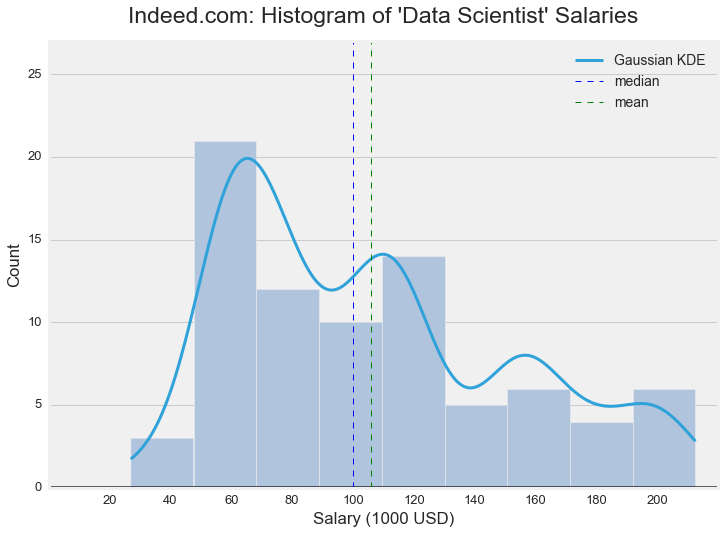

In [10]:
plt.figure(figsize = (12,8))
plt.style.use('fivethirtyeight')

df['salary'].hist(bins = 9, color = 'lightsteelblue')

density = gaussian_kde(df['salary'])
xs = np.linspace(df['salary'].min(), df['salary'].max(), 1000)
density.covariance_factor = lambda : 0.25
density._compute_covariance()
plt.plot(xs,density(xs)*10000000/5.5, linewidth = 3.0, label = 'Gaussian KDE')

plt.title('Indeed.com: Histogram of \'Data Scientist\' Salaries', fontsize = 23, y = 1.03)
plt.ylim([0, 27])
plt.yticks(range(0, 30, 5), fontsize = 13)
plt.ylabel('Count')
plt.xlim([0, 200000])
plt.xticks(range(20000, 240000, 20000), range(20, 220, 20), fontsize = 13)
plt.xlabel('Salary (1000 USD)')

plt.axhline(0, color = 'black', alpha = 0.6)
plt.axvline(df['salary'].median(), color='b', linestyle='dashed', linewidth=1.0, \
            label = 'median')
plt.axvline(df['salary'].mean(), color='g', linestyle='dashed', linewidth=1.0, \
            label = 'mean')

plt.grid(which='major', axis = 'x')
plt.legend(loc = 'best', fontsize = 14)
plt.show()

And now, let's see a bar chart of all the states included in the scrape:

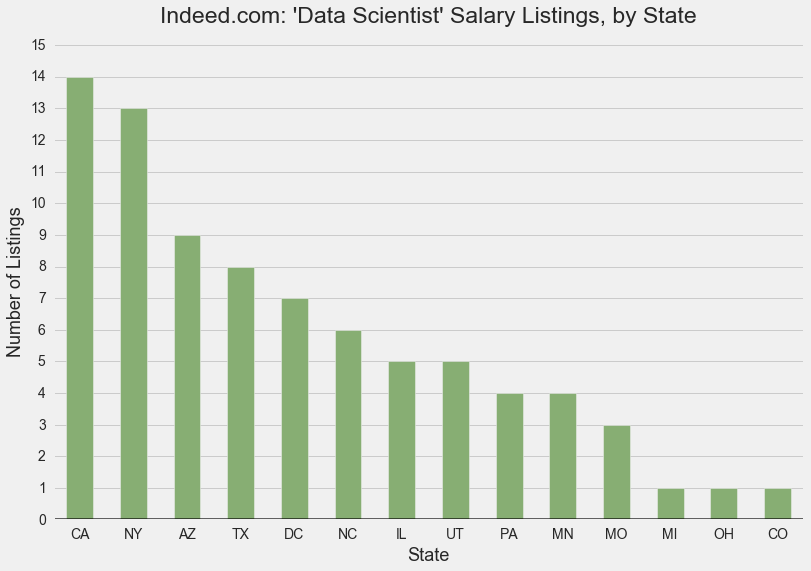

In [11]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df['state'].value_counts().plot.bar(color = 'sage')

plt.axhline(0, color='black', alpha = 0.6)

plt.title('Indeed.com: \'Data Scientist\' Salary Listings, by State', fontsize = 23, y = 1.03)

# y label
plt.ylabel('Number of Listings', fontsize = 18)
plt.yticks(range(0, 16, 1), fontsize = 14)
plt.ylim([0, 15.1])

# x label
plt.xlabel('State', fontsize = 18)
plt.xticks(rotation = 0, fontsize = 14)

plt.grid(which = 'major', axis = 'x')

plt.show()

And a bar chart of all the cities included in the scrape:

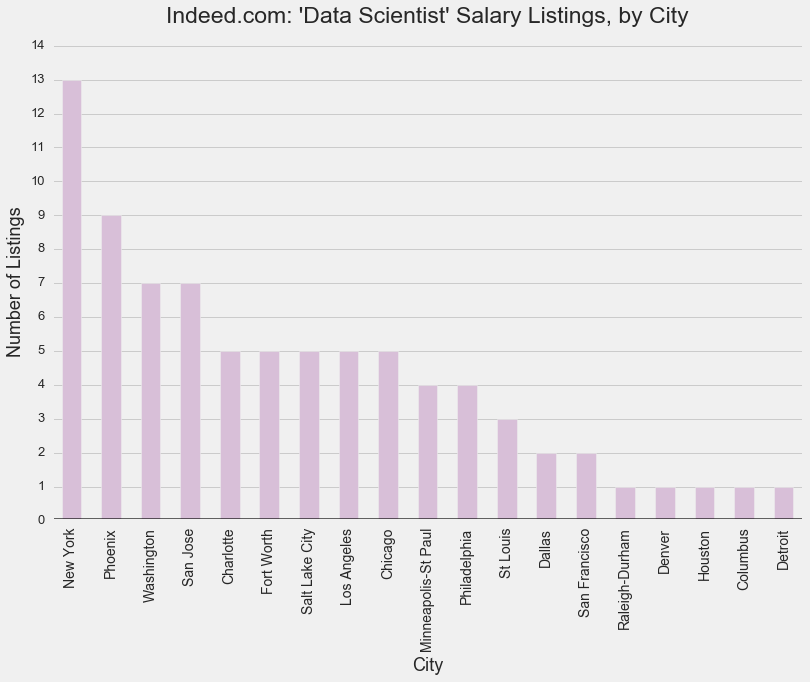

In [12]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df['city'].value_counts().plot.bar(color = 'thistle', alpha = 1.0)

plt.axhline(0, color='black', alpha = 0.6)

plt.title('Indeed.com: \'Data Scientist\' Salary Listings, by City', fontsize = 23, y = 1.03)

# y label
plt.ylabel('Number of Listings', fontsize = 18)
plt.ylim([0, 14.1])
plt.yticks(range(0, 15, 1), fontsize = 13)

# x label
plt.xlabel('City', fontsize = 18)
plt.xticks(fontsize = 14)

plt.grid(which = 'major', axis = 'x')

plt.show()

In [13]:
print 'The minimum salary listed is %s' %min(df['salary'])
df[df['salary'] == min(df['salary'])][['title', 'location', 'company', 'salary']]

The minimum salary listed is 27000.0


,title,location,company,salary
37,Data Science Engineer,"Boulder, CO",University of Colorado,27000.0


In [14]:
print 'The maximum salary listed is %s' %max(df['salary'])
df[df['salary'] == max(df['salary'])][['title', 'location', 'company', 'salary']]

The maximum salary listed is 212500.0


,title,location,company,salary
125,Applied Scientist,"New York, NY",Averity,212500.0


#### Compute the median salary and create a new binary target variable with 1 if the salary is above the median, and 0 otherwise:

In [15]:
df['target'] = [1 if x > df['salary'].median() else 0 for x in df['salary']]

In [16]:
df['salary'].median()

100000.0

Let's see it if looks like a 50-50 split of observations:

In [17]:
df['target'].value_counts()

0    41
1    40
Name: target, dtype: int64

Make a list of (non-unique) terms found in 'title' entries; ignore case and symbols:

In [19]:
df['title1'] = df['title'].apply(lambda x: re.sub(r'[^\w]', ' ', x.lower()))
df['title1'] = df['title1'].apply(lambda x: x.replace(' ai ', ' artificialintelligence '))
df['title1'] = df['title1'].apply(lambda x: x.replace('2', 'ii'))
df['title1'] = df['title1'].apply(lambda x: x.replace('artificial intelligence', 'artificialintelligence'))
df['title1'] = df['title1'].apply(lambda x: x.replace('machine learning', 'machinelearning'))
df['title1'] = df['title1'].apply(lambda x: x.replace('big data', 'bigdata'))
df['title1'] = df['title1'].apply(lambda x: x.replace('data scientist', 'datascience'))
df['title1'] = df['title1'].apply(lambda x: x.replace('data science', 'datascience'))
df['title1'] = df['title1'].apply(lambda x: x.replace('computer scientist', 'computerscientist'))
df['title1'] = df['title1'].apply(lambda x: x.replace(' sr ', ' senior '))
df['title1'] = df['title1'].apply(lambda x: x.replace(' jr ', ' junior '))
df['title1'] = df['title1'].apply(lambda x: list(set(x.split())))
df['title2'] = [None]*len(df)

df = df.reset_index(drop = True)

stemmer = PorterStemmer()

for i in range(len(df)):
    df['title2'][i] = [x for x in df['title1'][i] if len(x) > 1]
    df['title2'][i] = [x.strip() for x in df['title2'][i]]
    df['title2'][i] = [stemmer.stem(x) for x in df['title2'][i]]

In [20]:
all_terms = []
for i in df['title2']:
    i = list(set(i))
    all_terms = all_terms + i
unique_terms = list(set(all_terms))
term_counts = []
for i in unique_terms:
    count = all_terms.count(i)
    term_counts.append(count)
count_df = pd.DataFrame([unique_terms, term_counts]).T
count_df.columns = ['term', 'count']
count_df = count_df[count_df['count'] > 1]
count_df = count_df.sort_values(by = 'count', ascending = False)
count_df

,term,count
7,datasci,57
14,engin,10
6,scientist,9
27,analyt,6
20,bigdata,6
26,appli,5
22,analyst,5
1,nlp,5
8,research,5
5,ii,5


In [21]:
terms = count_df[count_df['count'] > 1]['term']            

In [22]:
def dummies(feature, terms):
    lil_df = pd.DataFrame()
    for term in terms:
        name = '_' + str(term) + '_'
        lil_df[name] = [1 if term in x else 0 for x in feature]
    return lil_df

In [23]:
dummy_df = dummies(df['title2'], terms)

In [24]:
big_df = pd.concat([df.drop(['title1', 'title2'], axis = 1), dummy_df], axis = 1)

In [25]:
df.groupby(['state', 'city'])['title'].count()

state  city               
AZ     Phoenix                 9
CA     Los Angeles             5
       San Francisco           2
       San Jose                7
CO     Denver                  1
DC     Washington              7
IL     Chicago                 5
MI     Detroit                 1
MN     Minneapolis-St Paul     4
MO     St Louis                3
NC     Charlotte               5
       Raleigh-Durham          1
NY     New York               13
OH     Columbus                1
PA     Philadelphia            4
TX     Dallas                  2
       Fort Worth              5
       Houston                 1
UT     Salt Lake City          5
Name: title, dtype: int64

In [26]:
CA = ['Los Angeles', 'San Francisco', 'San Jose']
NC = ['Charlotte', 'Raleigh-Durham']
TX = ['Dallas', 'Fort Worth', 'Houston']

big_df['is_CA'] = [1 if x in CA else 0 for x in big_df['city']]
big_df['is_NC'] = [1 if x in NC else 0 for x in big_df['city']]
big_df['is_TX'] = [1 if x in TX else 0 for x in big_df['city']]

In [27]:
big_df = pd.concat([big_df.drop(['city', 'state'], axis = 1), 
                    pd.get_dummies(big_df['city'])], axis = 1)

big_df.drop(['New York'], axis = 1, inplace = True)

In [28]:
big_df.head(1)

,title,location,company,salary,target,_datasci_,_engin_,_scientist_,_analyt_,_bigdata_,...,Los Angeles,Minneapolis-St Paul,Philadelphia,Phoenix,Raleigh-Durham,Salt Lake City,San Francisco,San Jose,St Louis,Washington
0,Data Scientist,"St. Louis, MO",Washington University in St. Louis,54095.5,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Perform a logistic regression on the salary dummy column using the term dummy columns as model features:

In [29]:
big_df.columns

Index([u'title', u'location', u'company', u'salary', u'target', u'_datasci_',
       u'_engin_', u'_scientist_', u'_analyt_', u'_bigdata_', u'_appli_',
       u'_analyst_', u'_nlp_', u'_research_', u'_ii_', u'_manag_', u'_pharma_',
       u'_machinelearn_', u'_sr_', u'_softwar_', u'_develop_', u'_quantit_',
       u'_computerscientist_', u'_alexa_', u'_senior_', u'_open_', u'_ai_',
       u'_artifici_', u'_product_', u'_for_', u'_time_', u'_statist_',
       u'_data_', u'_market_', u'_perfect_', u'_fo_', u'_immedi_', u'_avail_',
       u'_junior_', u'_associ_', u'_consult_', u'_part_', u'_custom_',
       u'_model_', u'is_CA', u'is_NC', u'is_TX', u'Charlotte', u'Chicago',
       u'Columbus', u'Dallas', u'Denver', u'Detroit', u'Fort Worth',
       u'Houston', u'Los Angeles', u'Minneapolis-St Paul', u'Philadelphia',
       u'Phoenix', u'Raleigh-Durham', u'Salt Lake City', u'San Francisco',
       u'San Jose', u'St Louis', u'Washington'],
      dtype='object')

In [30]:
X = big_df.drop(['title', 'location', 'company', 'salary', 'target'], axis = 1)

y = big_df['target']

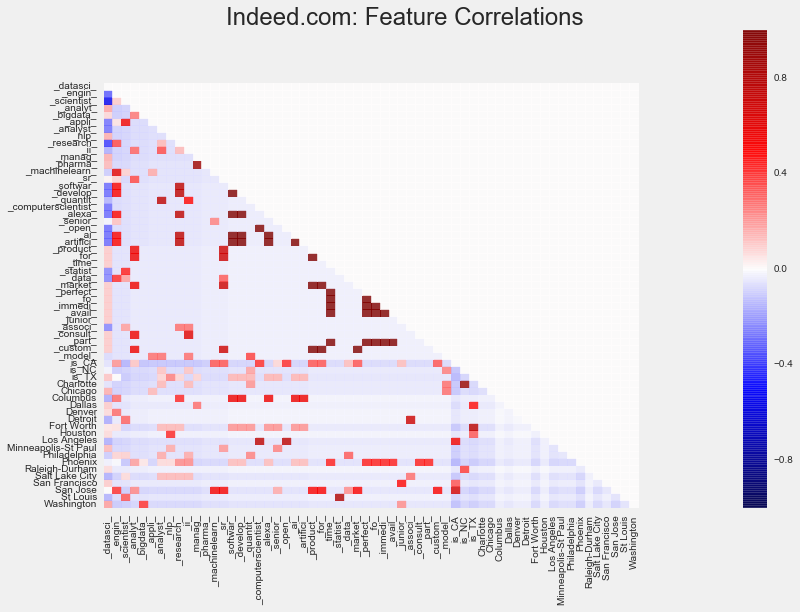

In [31]:
plt.figure(figsize = (12, 8))
plt.style.use('fivethirtyeight')

corr_mat = np.tril(X.corr(), k=-1)
sns.heatmap(corr_mat, cmap = 'seismic', alpha = 0.8)
plt.title('Indeed.com: Feature Correlations', fontsize = 24)
plt.xticks(np.arange(0.5, 68.5, 1), X.columns, fontsize = 10, rotation = 90)
plt.yticks(np.arange(0.5, 68.5, 1), list(X.columns)[::-1], fontsize = 10, rotation = 0)
plt.show()

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [33]:
parameters = {
    'penalty' : ['l1', 'l2'],
    'C' : [0.01, 0.1, 0.5, 1.0, 5, 10, 100],
}

lr = LogisticRegression(fit_intercept = True, random_state=42, n_jobs = -1)

clf = GridSearchCV(lr, parameters, cv = 5)

clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 0.5, 1.0, 5, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [34]:
clf.best_params_

{'C': 5, 'penalty': 'l2'}

In [35]:
lr2 = LogisticRegression(fit_intercept = True, C = 5, penalty = 'l2', random_state = 42)

lr2.fit(X_train, y_train)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
predictions = lr2.predict(X_test)
cm = confusion_matrix(predictions, y_test)
cm

array([[ 8,  3],
       [ 2, 12]])

In [37]:
accuracy_score(predictions, y_test)

0.80000000000000004

In [38]:
coefs = pd.DataFrame(index = X.columns)
coefs['coef'] = list(lr2.coef_)[0]
coefs['color'] = ['blue' if x <=0 else 'red' for x in coefs['coef']]
coefs['coef'] = [abs(x) for x in coefs['coef']]
coefs = coefs.sort_values(by = 'coef', ascending = False)

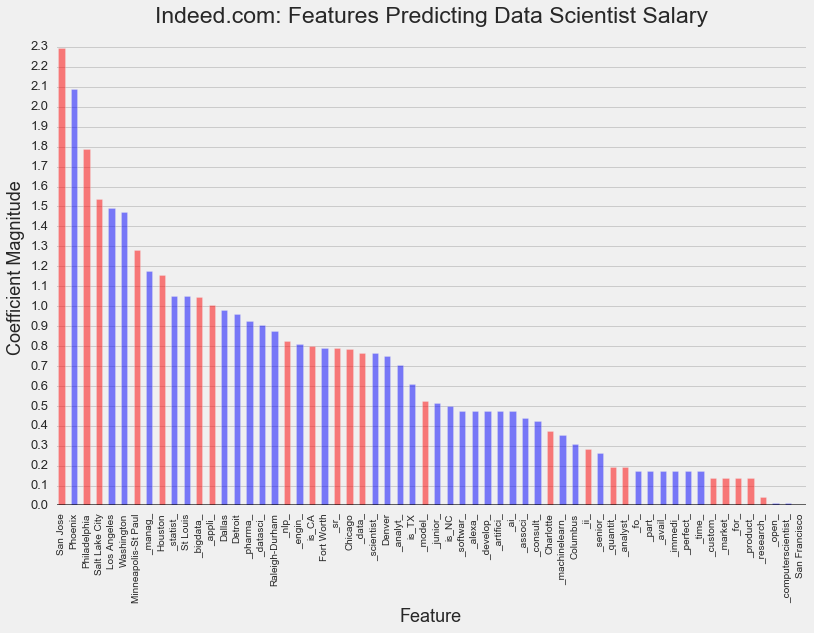

In [39]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

coefs['coef'].plot.bar(color = coefs['color'], alpha = 0.5)

plt.axhline(0, color='black', alpha = 0.6)

plt.title('Indeed.com: Features Predicting Data Scientist Salary', fontsize = 23)

plt.ylabel('Coefficient Magnitude', fontsize = 18)
plt.ylim([0, coefs['coef'].max() + 0.1])
plt.yticks(np.arange(0, coefs['coef'].max() + 0.1, 0.1), fontsize = 13)

plt.xlabel('Feature', fontsize = 18)
plt.xticks(fontsize = 10)

plt.grid(which = 'major', axis = 'x')

plt.show()

In [40]:
accuracies = []
precisions = []
recalls = []

for i in range(1, len(X.columns)):
    pick_em = SelectKBest(f_classif, k=i)
    pick_em.fit(X_train, y_train)
    support = X.columns[pick_em.get_support()]
    lr2.fit(X_train[support], y_train)
    y_pred = lr2.predict(X_test[support])
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    
results = pd.DataFrame(index = range(len(X.columns) - 1))
results['accuracy'] = accuracies
results['precision'] = precisions
results['recall'] = recalls

In [41]:
results.head()

,accuracy,precision,recall
0,0.48,1.0,0.133333
1,0.48,1.0,0.133333
2,0.52,1.0,0.200000
3,0.52,1.0,0.200000
4,0.64,1.0,0.400000


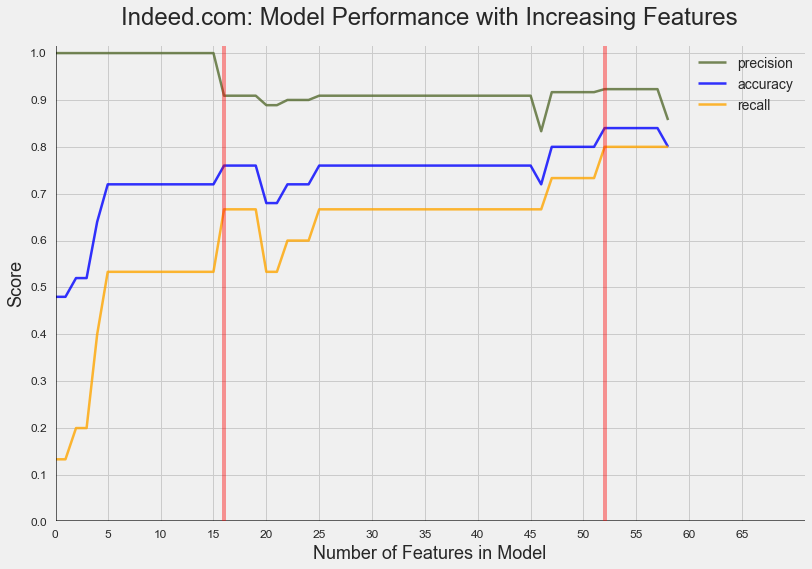

In [42]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

for i in [('precision', 'DarkOliveGreen'), ('accuracy', 'blue'), ('recall', 'Orange')]:
    plt.plot(results.index, results[i[0]], color = i[1], linewidth = 2.5, \
         label = i[0], alpha = 0.8)

plt.axhline(0, color='black', alpha = 0.6)
plt.axvline(0, color='black', alpha = 0.6)
plt.title('Indeed.com: Model Performance with Increasing Features', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Score', fontsize = 18)
plt.yticks(np.arange(0, 1.2, 0.1), fontsize = 12)

# x label
plt.xlabel('Number of Features in Model', y = 0.1, fontsize = 18)
plt.xticks(range(0, 70, 5), fontsize = 12)

plt.xlim([-0.1, 71])
plt.ylim([0.0, 1.02])
plt.legend(loc='best', fontsize = 14)

plt.axvline(16, color = 'red', alpha = 0.4)
plt.axvline(52, color = 'red', alpha = 0.4)

plt.show()

In [44]:
pick_em = SelectKBest(f_classif, k=16)
pick_em.fit(X_train, y_train)
support = X.columns[pick_em.get_support()]
support

Index([u'_manag_', u'_sr_', u'_softwar_', u'_develop_', u'_alexa_', u'_ai_',
       u'_artifici_', u'is_CA', u'Fort Worth', u'Minneapolis-St Paul',
       u'Philadelphia', u'Phoenix', u'Salt Lake City', u'San Jose',
       u'St Louis', u'Washington'],
      dtype='object')

In [45]:
lr2.fit(X_train[support], y_train)
predictions = lr2.predict(X_test[support])
cm = confusion_matrix(predictions, y_test)
cm

array([[10,  7],
       [ 0,  8]])

In [46]:
def plot_confusion_matrix(cm, title='Confusion matrix', labels=['Positive','Negative'], \
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, labels, fontsize = 14)
    plt.yticks(tick_marks, labels, rotation = 90, fontsize = 14)
        
    plt.title(title, fontsize = 24)
    plt.ylabel('True label', fontsize = 18)
    plt.xlabel('Predicted label', fontsize = 18)
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=40).set_path_effects([path_effects.Stroke(linewidth=1, \
                            foreground='black'), path_effects.Normal()])
    return

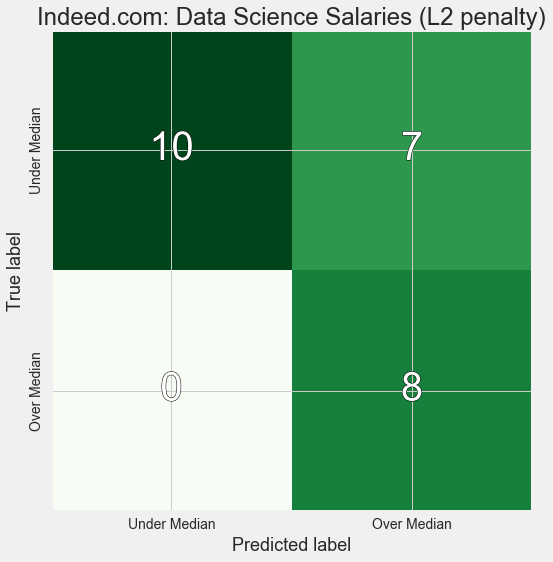

In [47]:
plot_confusion_matrix(cm, title='Indeed.com: Data Science Salaries (L2 penalty)', \
                      labels=['Under Median', 'Over Median'], cmap=plt.cm.Greens)

In [48]:
def auc_plotting_function(rate1, rate2, rate1_name, rate2_name, median):
    AUC = auc(rate1, rate2)
    # Plot of a ROC curve for class 1 (above median salary)
    plt.figure(figsize=(12,8))
    plt.style.use('fivethirtyeight')
    plt.plot(rate1, rate2, label = 'ROC (area = %0.2f)' % AUC, linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2.5, alpha = 0.5, color = 'magenta')
    plt.xlim([-0.025, 1.01])
    plt.xticks(fontsize = 13)
    plt.ylim([-0.025, 1.05])
    plt.yticks(fontsize = 13)
    plt.xlabel(rate1_name, fontsize=18)
    plt.ylabel(rate2_name, fontsize=18)
    plt.title('ROC for Data Science Salaries > %s' %median, fontsize=18)
    plt.legend(loc="best", fontsize = 12)
    plt.axvline(0, linewidth = 1, alpha = 0.5, color = 'black')
    plt.axhline(0, linewidth = 1, alpha = 0.5, color = 'black')
    plt.show()

# plot receiving operator characteristic curve
def plot_roc(y_true, y_score, median):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_plotting_function(fpr, tpr, 'False Positive Rate', 'True Positive Rate', median)

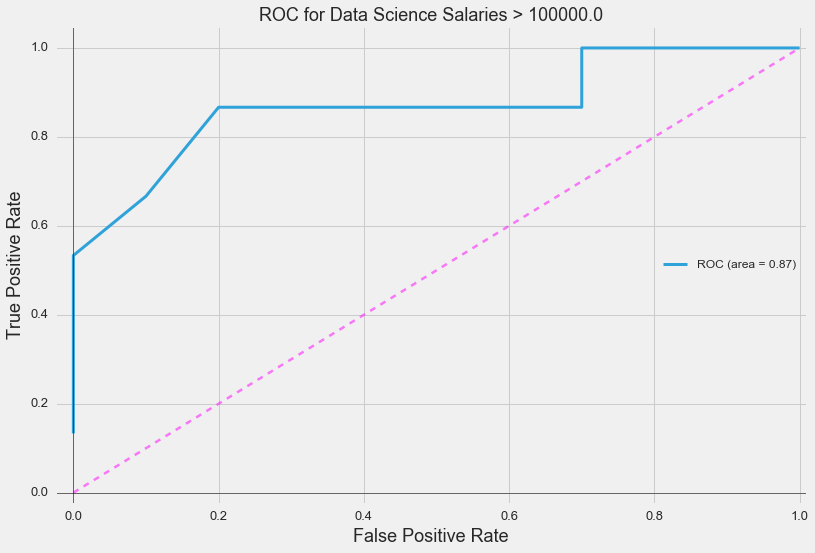

In [49]:
y_score = lr2.decision_function(X_test[support])
plot_roc(y_test, y_score, df['salary'].median())